# Comparison of Cosine Tracking (CST & CSVT) & Wavelet Tracking (WST & WSVT)

With the transformed signals truncated to the same number of points, the CST & CSVT
methods exhibit less noise than the WST & WSVT methods respectively.

In [25]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from mbipy.numpy.phase_retrieval import cst, wst, csvt, wsvt

with h5py.File("./data/BeLens.h5", "r") as f:
    sample = f["50"]["sample"][:]
    reference = f["50"]["reference"][:]

    sample = sample.astype(np.float64) / np.iinfo(sample.dtype).max
    reference = reference.astype(np.float64) / np.iinfo(reference.dtype).max

sample.shape, reference.shape

((10, 900, 900), (10, 900, 900))

In [26]:
def plot_results(titles, results, figsize=None):
    assert len(titles) == len(results)
    size = len(results)
    fig = plt.figure(layout="constrained", figsize=figsize or (8, 8 * size))
    subfigs = fig.subfigures(size, 1, wspace=0.07)
    for i, j in enumerate(titles):
        subfigs[i].suptitle(j)

    for i, j in enumerate(results):
        axes = subfigs[i].subplots(1, 6)  # , sharex=True, sharey=True)
        im0 = axes[0].imshow(j[0])
        im1 = axes[1].imshow(j[1])
        plt.colorbar(im0, ax=axes[0], fraction=0.05, pad=0.04)
        plt.colorbar(im1, ax=axes[1], fraction=0.05, pad=0.04)
        axes[2].plot(j[0][460:470].mean(axis=0))
        axes[3].plot(j[1][460:470].mean(axis=0))
        axes[4].plot(j[0][:, 400:410].mean(axis=1))
        axes[5].plot(j[1][:, 400:410].mean(axis=1))

In [38]:
N = 0
ss = (17, 17)
ts = (7, 7)

# Truncates the transformed vector from np.prod(ts) to cutoff
cutoff = 15

In [41]:
%%time
result_cst = cst(reference[N], sample[N], ss, ts, dct_kwargs={"workers": 8}, cutoff=cutoff)

CPU times: user 3.58 s, sys: 717 ms, total: 4.3 s
Wall time: 4.03 s


In [42]:
%%time
result_wst = wst(reference[N], sample[N], ss, ts, cutoff=cutoff, level_cutoff=3)

CPU times: user 3.64 s, sys: 1.37 s, total: 5.01 s
Wall time: 5.95 s


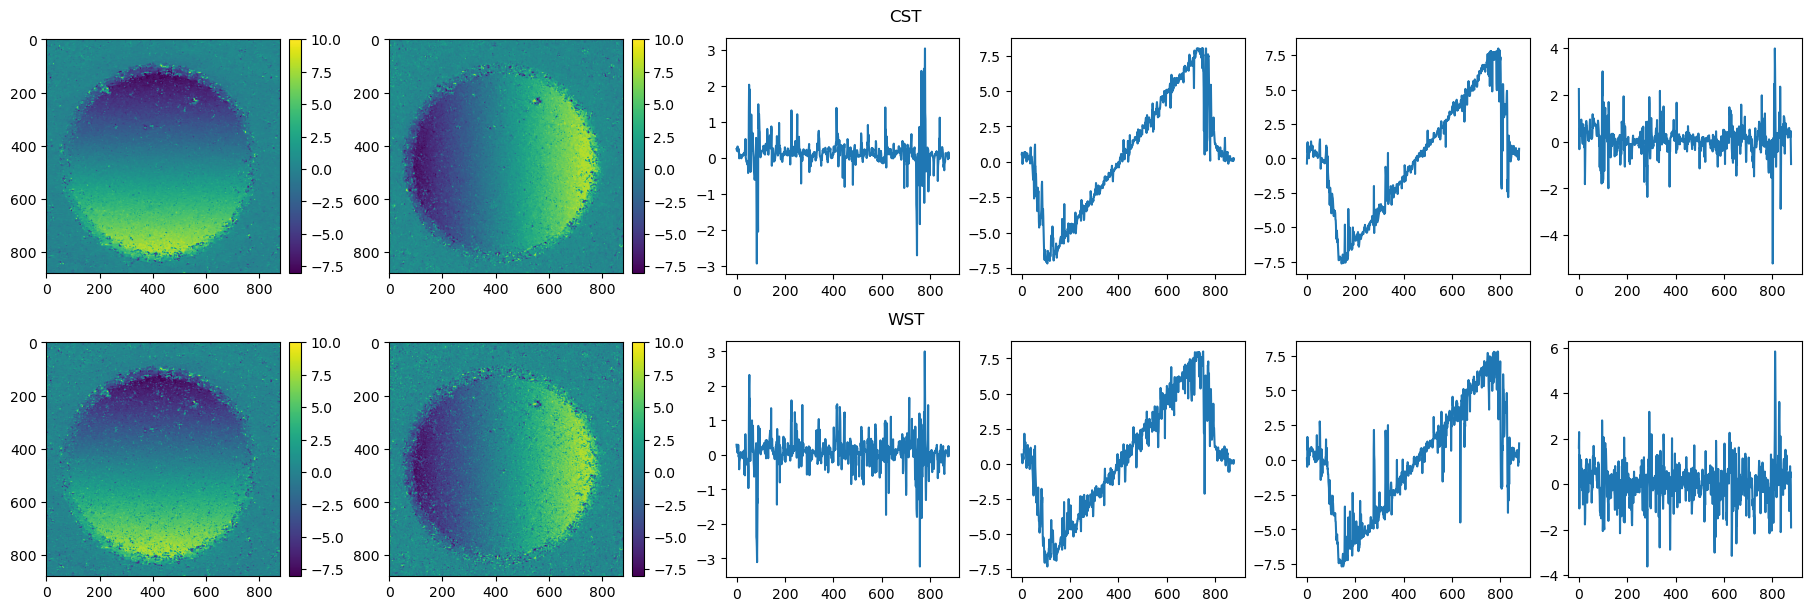

In [30]:
plot_results(["CST", "WST"], [result_cst, result_wst], (18, 6))

In [34]:
# Truncates the transformed vector from image.shape[-3] to cutoff
cutoff = 5
reference.shape, sample.shape

((10, 900, 900), (10, 900, 900))

In [35]:
%%time
result_csvt = csvt(reference, sample, 8, 8, dct_kwargs={"workers": 8}, cutoff=cutoff)

CPU times: user 3.45 s, sys: 1.07 s, total: 4.51 s
Wall time: 5.36 s


In [36]:
%%time
result_wsvt = wsvt(reference, sample, 8, 8, cutoff=cutoff)

CPU times: user 3.52 s, sys: 1.28 s, total: 4.8 s
Wall time: 6.01 s


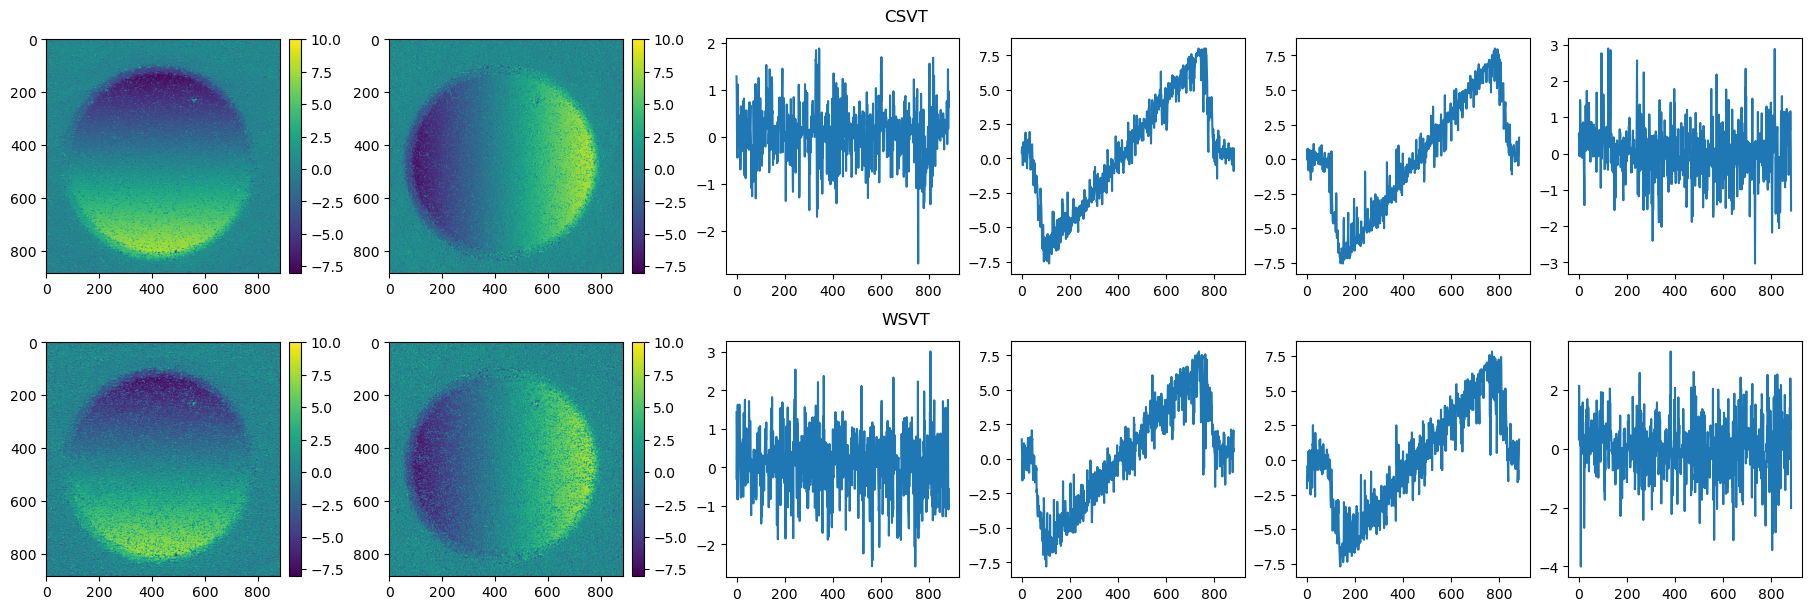

In [37]:
plot_results(["CSVT", "WSVT"], [result_csvt, result_wsvt], (18, 6))

In [22]:
import pywt
from scipy import fft

rng = np.random.default_rng()

img = rng.random((10, 900, 900))

# DCT & DWT performed in the speckle vector tracking methods
%timeit fft.dct(img, axis=-3, norm="ortho", workers=1)
%timeit pywt.wavedec(img, "db2", mode="zero", axis=-3)

img_swv = np.lib.stride_tricks.sliding_window_view(img[0], (7, 7), axis=(-2, -1))
img_swv = img_swv.reshape(img_swv.shape[:-2] + (-1,))

# DCT & DWT performed in the speckle tracking methods
%timeit fft.dct(img_swv, axis=-1, norm="ortho", workers=1)
%timeit pywt.wavedec(img_swv, "db2", mode="zero", axis=-1)

30.1 ms ± 430 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.9 ms ± 678 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
176 ms ± 838 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
276 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
